## <center><font color=navy>Big Data Economics</font></center>
### <center>Case Study: Adult Census Income Level Prediction</center>
#### <center>Ali Habibnia</center>
    
<center> Assistant Professor, Department of Economics, </center>
<center> and Division of Computational Modeling & Data Analytics at Virginia Tech</center>
<center> habibnia@vt.edu </center> 

<img style="float: right;" src='images/income.png' style='width: 25%'/> 


The prominent inequality of wealth and income is a huge concern especially in the United States. 
> See [Thomas Piketty's 'Capital' in 3 minutes](https://www.youtube.com/watch?v=HL-YUTFqtuI&frags=pl%2Cwn) & [Capital in the Twenty-First Century](https://www.youtube.com/watch?v=JXOLiJY2EhgThe) 

likelihood of diminishing poverty is one valid reason to reduce the world's surging level of economic inequality. The principle of universal moral equality ensures **sustainable developmen**t and improve the **economic stability** of a nation. 

Governments in different countries have been trying their best to address this problem and provide an optimal solution. 

This is an analysis of the Adult data set in the UCI Machine Learning Repository. This data set is meant for binary class classification. 

For this problem, we want to propose a model that can predict whether a person makes over $50K/yr based on census data of about 32000 people. 

The data given for each individual includes

1) Age 2) Workclass 3) Financial weight 4) Education 5) Education-num 6) Marital status 7) Occupation 8) Relationship 9) Race 10) Sex 11) Capital gain 12) Capital loss 13) Hour per week 14) Native country 15) Target

Given the 14 attributes, you are going to predict the Target column. The data occasionally has missing values. Moreover, features might be numerical, ordinal or nominal. 

In [0]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from pandas.api.types import CategoricalDtype

First we download the data as a Pandas DataFrame. The missing values are shown with the question mark symbol. Notice how I took this into account when I loaded data:

In [0]:
table = pd.read_excel('https://spreadsheets.google.com/feeds/download/spreadsheets/Export?key=1847M6fEzAm2z2aO3UonIlPwdOMdIchUUryNCLnOoFxQ',
                     names=[
                      "Age", "Workclass", "FnlWgt", "Edu", "EduNum", "Marital",
                      "Occupation", "Relationship", "Race", "Sex", "CapGain", "CapLoss",
                      "HoursWeek", "Country", "Target"],
                     na_values="?")

Then we inspect the data:

In [7]:
table.head()

,Age,Workclass,FnlWgt,Edu,EduNum,Marital,Occupation,Relationship,Race,Sex,CapGain,CapLoss,HoursWeek,Country,Target
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [0]:
table.shape

(32560, 15)

To see which columns have missing values, we can run the command below:

In [8]:
table.isna().sum()

Age                0
Workclass       1836
FnlWgt             0
Edu                0
EduNum             0
Marital            0
Occupation      1843
Relationship       0
Race               0
Sex                0
CapGain            0
CapLoss            0
HoursWeek          0
Country          583
Target             0
dtype: int64

We can see that the three columns, namely, Workclass, Occupation and Country, have some missing values. 

There are numerous ways to handle missing values. One way would be replacing the missing values with the most frequent value. See the following link to learn more about some of these approaches:
https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html

Here I opt to simply remove rows with at least on missing value:

In [9]:
df = table.dropna(axis=0).copy()
print("Number of rows removed:", table.shape[0] - df.shape[0])

Number of rows removed: 2399


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30161 entries, 0 to 32559
Data columns (total 15 columns):
Age             30161 non-null int64
Workclass       30161 non-null object
FnlWgt          30161 non-null int64
Edu             30161 non-null object
EduNum          30161 non-null int64
Marital         30161 non-null object
Occupation      30161 non-null object
Relationship    30161 non-null object
Race            30161 non-null object
Sex             30161 non-null object
CapGain         30161 non-null int64
CapLoss         30161 non-null int64
HoursWeek       30161 non-null int64
Country         30161 non-null object
Target          30161 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Let's now see the distribution of data:

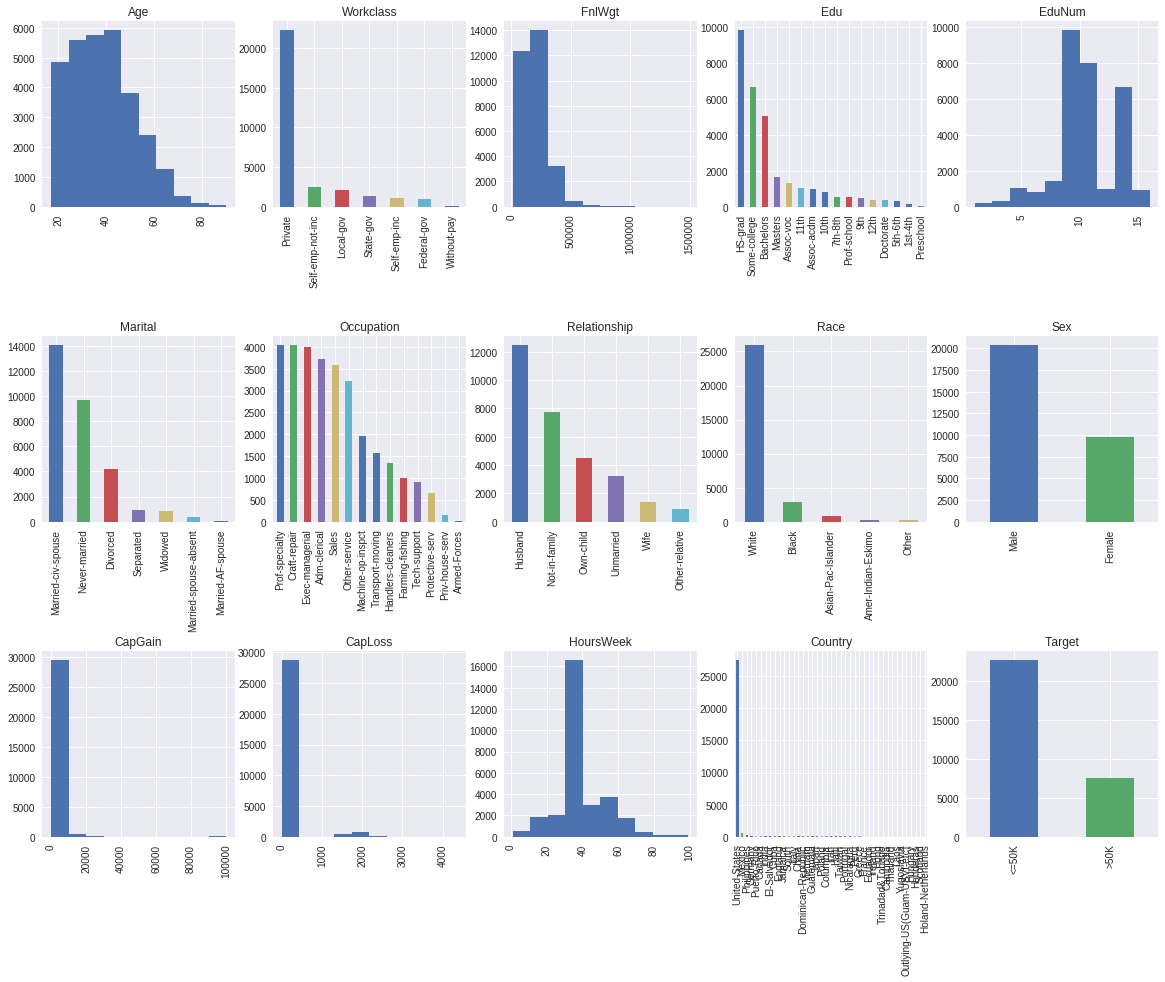

In [16]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = np.ceil(float(df.shape[1]) / cols)
for i, column in enumerate(df.columns):
  ax = fig.add_subplot(rows, cols, i + 1)
  ax.set_title(column)
  if df.dtypes[column] == np.object:
    df[column].value_counts().plot(kind="bar", axes=ax)
  else:
      df[column].hist(axes=ax)
      plt.xticks(rotation="vertical")
  plt.subplots_adjust(hspace=0.7, wspace=0.2)

Now you have this insight that more than 90% of the people in the survey are from USA and white or that most of them work in the private sector. 

Notice that our data is imbalanced, that is we have twice the people earning less than 50K than the other way around. Severe class imbalance may badly affect the performance of some the models we studied. This case is not a deal breaker for us though.

Let's look at the correlation between these features. We need to encode categorical features as numerical ones to be able to calculate the correlations among them. Read the documentation for LabelEncoder for more information:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

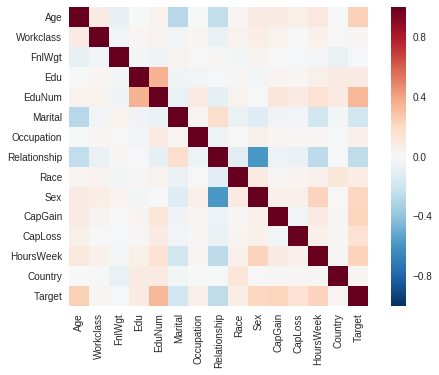

In [17]:
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

Look! There's high correlation between `Edu` and `EduNum`. There's not unexpected though,

In [18]:
df[["Edu", "EduNum"]].head(10)

,Edu,EduNum
0,Bachelors,13
1,HS-grad,9
2,11th,7
3,Bachelors,13
4,Masters,14
5,9th,5
6,HS-grad,9
7,Masters,14
8,Bachelors,13
9,Some-college,10


The columns in fact hold the same information. The reason we should care about this is that it's usually not a good idea to have collinear (highly correlated) features.  They may lead to decreased training speed, decreased generalization performance on the test and less model interpretability. This is especially true for linear models where it can result in unstable solution. It will become problematic to estimate the weights because the feature effects are additive and it becomes indeterminable to which of the correlated features to attribute the effects. Read [this](https://datascience.stackexchange.com/q/24452) for more information.


Anyways, we are going to remove one of these columns. Notice that it is a better idea to remove `Edu` as `EduNum` has valuable information on the ordering.

In [0]:
del df["Edu"]

You might notice that there is strong negative correlation between `Sex` and `Relationship`. There's no easy way to get around this problem here, so we proceed.

Let's see some statistics for the numerical data:

In [20]:
df.describe()

,Age,FnlWgt,EduNum,CapGain,CapLoss,HoursWeek
count,30161.000000,3.016100e+04,30161.000000,30161.000000,30161.000000,30161.000000
mean,38.437883,1.897976e+05,10.121216,1091.971984,88.375419,40.931269
std,13.134882,1.056527e+05,2.549983,7406.466659,404.304753,11.980182
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176280e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.784290e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.376300e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


All the machine learning models expect numerical values. So we need to encode the categorical features into numerical ones. We will use the `number_encode_features` function we wrote before to achieve this. Let's see the histogram of features now:

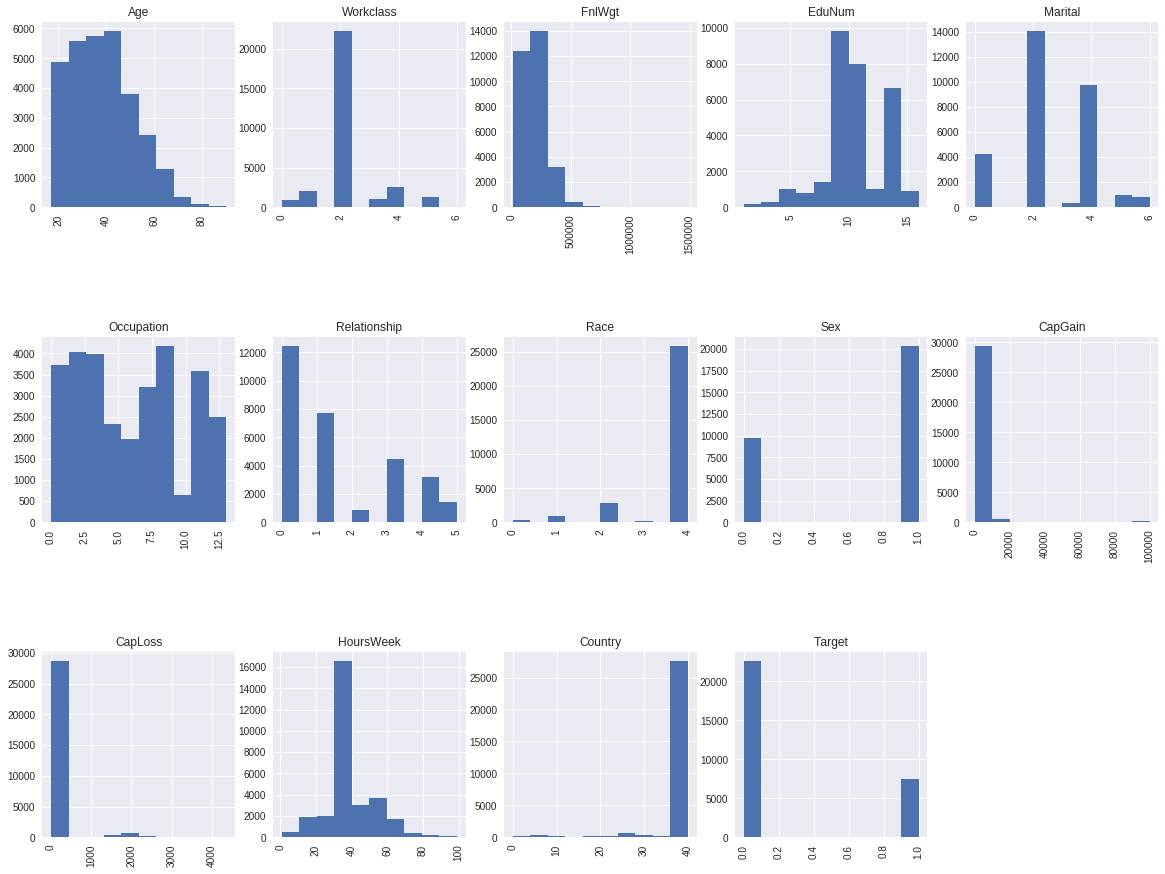

In [21]:
encoded_df, encoders = number_encode_features(df)
fig = plt.figure(figsize=(20,15))
cols = 5
rows = np.ceil(float(encoded_df.shape[1]) / cols)
for i, column in enumerate(encoded_df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_df[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

There's another thing. With the exception of neural networks, it is usually better to normalize or standardize data. That is to scale features such that they have mean 0 and variance 1. For this, you can use  [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) of `sklearn`.

In [0]:
scaler = preprocessing.StandardScaler()
df_scaled = encoded_df.copy()
desired_cols = df_scaled.columns.tolist()
desired_cols.remove('Target')
df_scaled[desired_cols] = preprocessing.StandardScaler().fit_transform(df_scaled.astype('float64')[desired_cols])

In [24]:
df_scaled.head(5)

,Age,Workclass,FnlWgt,EduNum,Marital,Occupation,Relationship,Race,Sex,CapGain,CapLoss,HoursWeek,Country,Target
0,0.880275,1.888018,-1.007909,1.128961,-0.387243,-0.734609,-0.885732,0.385055,0.692823,-0.147437,-0.21859,-2.331495,0.264929,0
1,-0.033338,-0.208884,0.244659,-0.439703,-1.722362,-0.238260,-0.261254,0.385055,0.692823,-0.147437,-0.21859,-0.077735,0.264929,0
2,1.108678,-0.208884,0.425206,-1.224035,-0.387243,-0.238260,-0.885732,-2.010994,0.692823,-0.147437,-0.21859,-0.077735,0.264929,0
3,-0.794682,-0.208884,1.406626,1.128961,-0.387243,0.754439,2.236660,-2.010994,-1.443370,-0.147437,-0.21859,-0.077735,-5.303944,0
4,-0.109472,-0.208884,0.897147,1.521127,-0.387243,-0.734609,2.236660,0.385055,-1.443370,-0.147437,-0.21859,-0.077735,0.264929,0


Now we split data into train and test partitions.

In [0]:
#Split train and test, with test holing 20% of the samples belonging to each class
df_class_0_train, df_class_0_test = train_test_split(df_scaled[df_scaled['Target']==0], test_size=0.2)
df_class_1_train, df_class_1_test = train_test_split(df_scaled[df_scaled['Target']==1], test_size=0.2)

train_df = pd.concat([df_class_0_train, df_class_1_train])
test_df  = pd.concat([df_class_0_test, df_class_1_test])

#Shuffle train data
train_df = train_df.sample(frac=1, random_state=0)

X_train = train_df.drop('Target', axis=1)
y_train = train_df['Target']

X_test = test_df.drop('Target', axis=1)
y_test = test_df['Target']

In [27]:
X_test.head()

,Age,Workclass,FnlWgt,EduNum,Marital,Occupation,Relationship,Race,Sex,CapGain,CapLoss,HoursWeek,Country
31236,-1.556026,-0.208884,0.395306,-0.439703,0.947877,1.250788,0.987703,0.385055,-1.443370,-0.147437,-0.21859,-0.662043,0.264929
5064,-0.414010,1.888018,1.001348,-3.184864,0.280317,-0.982784,-0.261254,0.385055,0.692823,-0.147437,-0.21859,-0.077735,-1.864346
18996,1.337081,-0.208884,0.429787,-0.439703,2.282996,0.258090,1.612182,0.385055,-1.443370,-0.147437,-0.21859,-0.077735,0.264929
20324,-1.099220,-0.208884,0.812992,-1.224035,0.947877,1.747138,0.987703,0.385055,0.692823,-0.147437,-0.21859,-0.161208,0.264929
23833,0.804141,-0.208884,0.445954,-0.439703,2.282996,0.258090,-0.261254,0.385055,-1.443370,-0.147437,-0.21859,0.339627,0.264929


In [29]:
cls = LogisticRegression(solver='lbfgs')
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print("F1 score: {:6f}".format(metrics.f1_score(y_test, y_pred)))
print("Accuracy: {:6f}".format(metrics.accuracy_score(y_test, y_pred)))

F1 score: 0.559968
Accuracy: 0.819990


popular performance metrics for classification: confusion matrix, accuracy, precision, recall, sensitivity, and specificity. See: [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)

Text(0.5, 28.5, 'Predicted value')

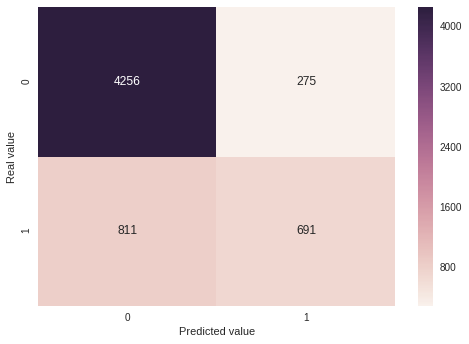

In [30]:
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

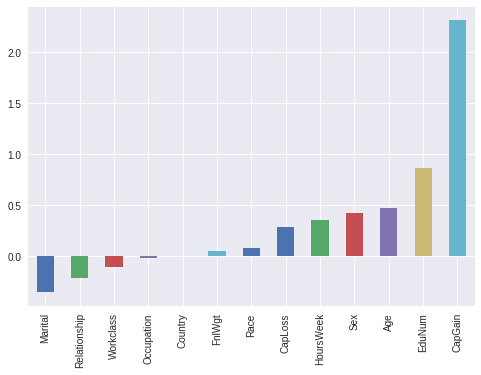

In [31]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
coefs.sort_values(inplace=True)
coefs.plot(kind="bar")

We can see that the feature `Capital Gain` is the most important feature for our Logistic Regression model. Notice that `Marital Status` and `Relationship` are not  unimportant, but have large negative coeffecients assigned to them.

OK. Not bad. We have correctly classified 82% of samples. However this should be taken with a grain of salt, as our imbalanced dataset means that a random willy-nilly classification would not have resulted in 50% accuracy. So other metrics, such as confusion matrix and F1 become more important.

See: [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

AUC: 0.6996801292824898


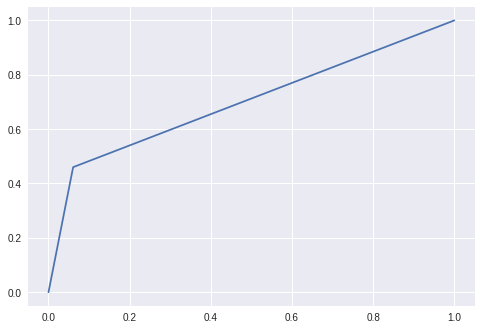

In [32]:
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="LogReg1")
print('AUC:', auc)

OK. I have to cofess that they way we dealt with encoding categorical features was not the best one! We need to perform preprocessing from scratch!

We will use [pd.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to convert the categorical values to numerical values (by one-hot encoding). Consider the case where we encode the categorical feature `Country` with a numerical value. The problem is that it would imply an ordering between different countries. Imagine that Sweden and Denmark are encoded with the numbers $42$ and $56$, respectively. This might falsely imply an unintentional ordering between the countries. To tackle this we use the method of [one-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). The way it works is simply replacing each feature value (e.g. country name) with a dummy feature holding `1` if the feature value is assumed and `0` otherwise. 


In [0]:
df_dummy = pd.get_dummies(df)

#Bring back original Target!
df_dummy["Target"] = df_dummy["Target_>50K"]
del df_dummy["Target_<=50K"]
del df_dummy["Target_>50K"]

See how the number of columns have grown:

In [34]:
df_dummy.columns

Index(['Age', 'FnlWgt', 'EduNum', 'CapGain', 'CapLoss', 'HoursWeek',
       'Workclass_Federal-gov', 'Workclass_Local-gov', 'Workclass_Private',
       'Workclass_Self-emp-inc', 'Workclass_Self-emp-not-inc',
       'Workclass_State-gov', 'Workclass_Without-pay', 'Marital_Divorced',
       'Marital_Married-AF-spouse', 'Marital_Married-civ-spouse',
       'Marital_Married-spouse-absent', 'Marital_Never-married',
       'Marital_Separated', 'Marital_Widowed', 'Occupation_Adm-clerical',
       'Occupation_Armed-Forces', 'Occupation_Craft-repair',
       'Occupation_Exec-managerial', 'Occupation_Farming-fishing',
       'Occupation_Handlers-cleaners', 'Occupation_Machine-op-inspct',
       'Occupation_Other-service', 'Occupation_Priv-house-serv',
       'Occupation_Prof-specialty', 'Occupation_Protective-serv',
       'Occupation_Sales', 'Occupation_Tech-support',
       'Occupation_Transport-moving', 'Relationship_Husband',
       'Relationship_Not-in-family', 'Relationship_Other-relative'

In [35]:
df_dummy.head()

,Age,FnlWgt,EduNum,CapGain,CapLoss,HoursWeek,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Private,Workclass_Self-emp-inc,...,Country_Puerto-Rico,Country_Scotland,Country_South,Country_Taiwan,Country_Thailand,Country_Trinadad&Tobago,Country_United-States,Country_Vietnam,Country_Yugoslavia,Target
0,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,28,338409,13,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,37,284582,14,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [0]:
scaler = preprocessing.StandardScaler()
df_dummy_scaled = df_dummy.copy()
desired_cols = df_dummy_scaled.columns.tolist()
desired_cols.remove('Target')
df_dummy_scaled[desired_cols] = preprocessing.StandardScaler().fit_transform(df_dummy_scaled.astype('float64')[desired_cols])

Let's see the correlation matrix for the transformed data:

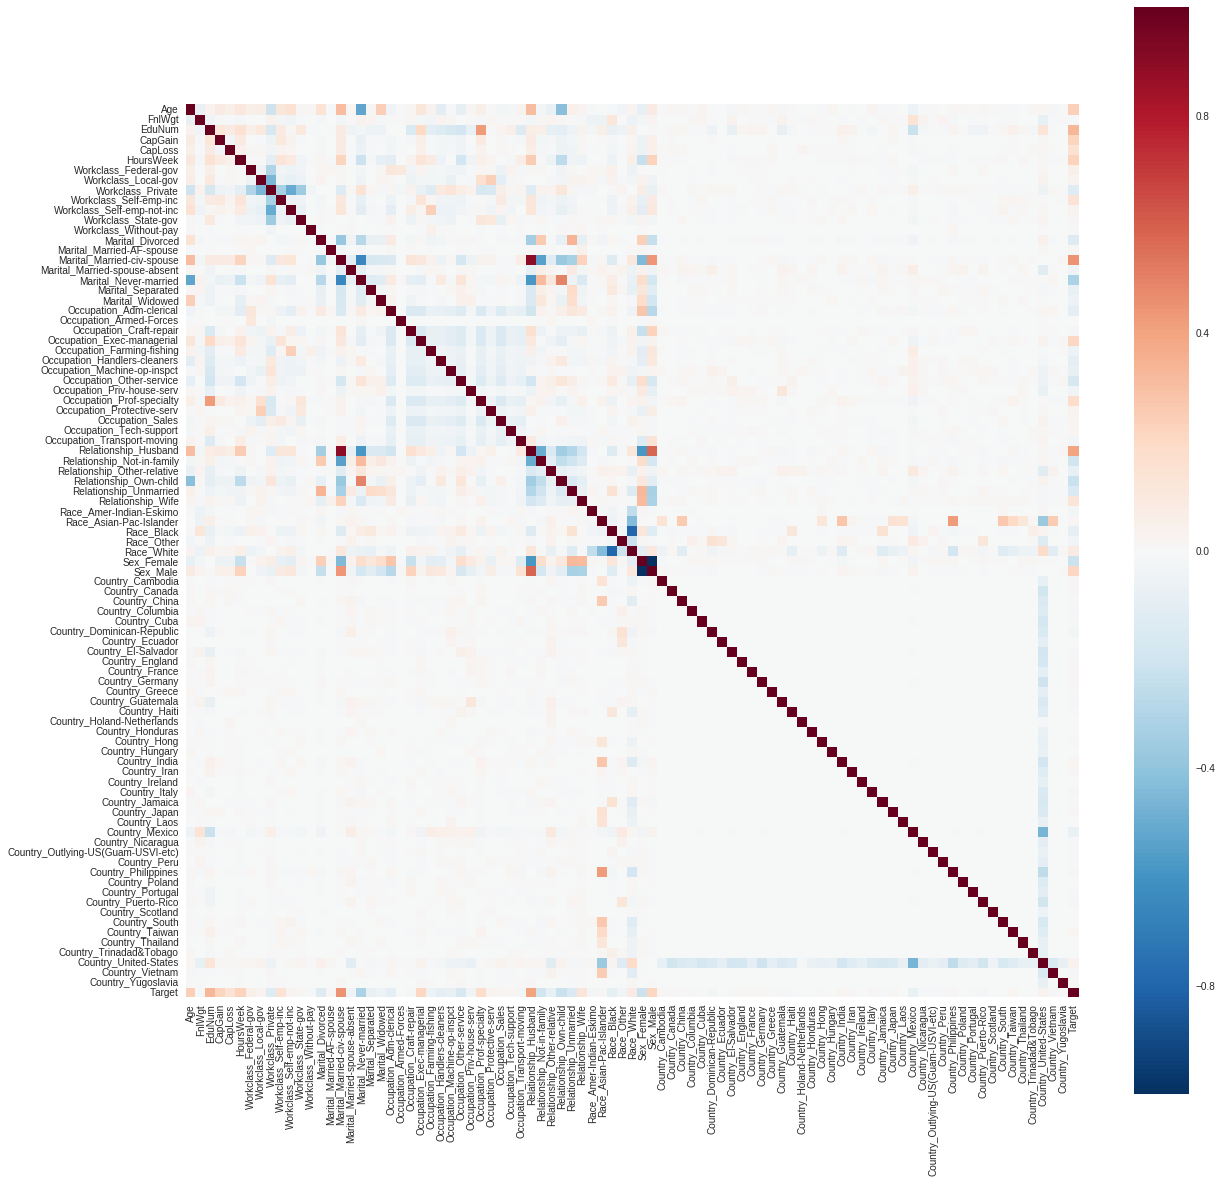

In [38]:
plt.figure(figsize=(20,20))
sns.heatmap(df_dummy_scaled.corr(), square=True)

One column for each categorical column-value pair.
Let's split the data again into train and test:

In [0]:
#Split train and test, with test holing 20% of the samples belonging to each class
df_class_0_train, df_class_0_test = train_test_split(df_dummy_scaled[df_dummy_scaled['Target']==0], test_size=0.2)
df_class_1_train, df_class_1_test = train_test_split(df_dummy_scaled[df_dummy_scaled['Target']==1], test_size=0.2)

train_df = pd.concat([df_class_0_train, df_class_1_train])
test_df  = pd.concat([df_class_0_test, df_class_1_test])

#Shuffle train data
train_df = train_df.sample(frac=1, random_state=0)

X_train = train_df.drop('Target', axis=1)
y_train = train_df['Target']

X_test = test_df.drop('Target', axis=1)
y_test = test_df['Target']

In [40]:
cls = LogisticRegression(solver='lbfgs')
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print("F1 score: {:6f}".format(metrics.f1_score(y_test, y_pred)))
print("Accuracy: {:6f}".format(metrics.accuracy_score(y_test, y_pred)))

F1 score: 0.674991
Accuracy: 0.848997


Nice! There's clearly a big jump in the performance.

Text(0.5, 28.5, 'Predicted value')

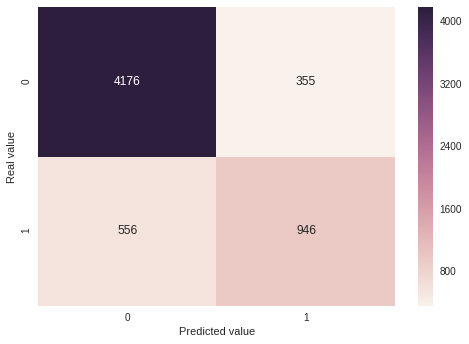

In [41]:
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

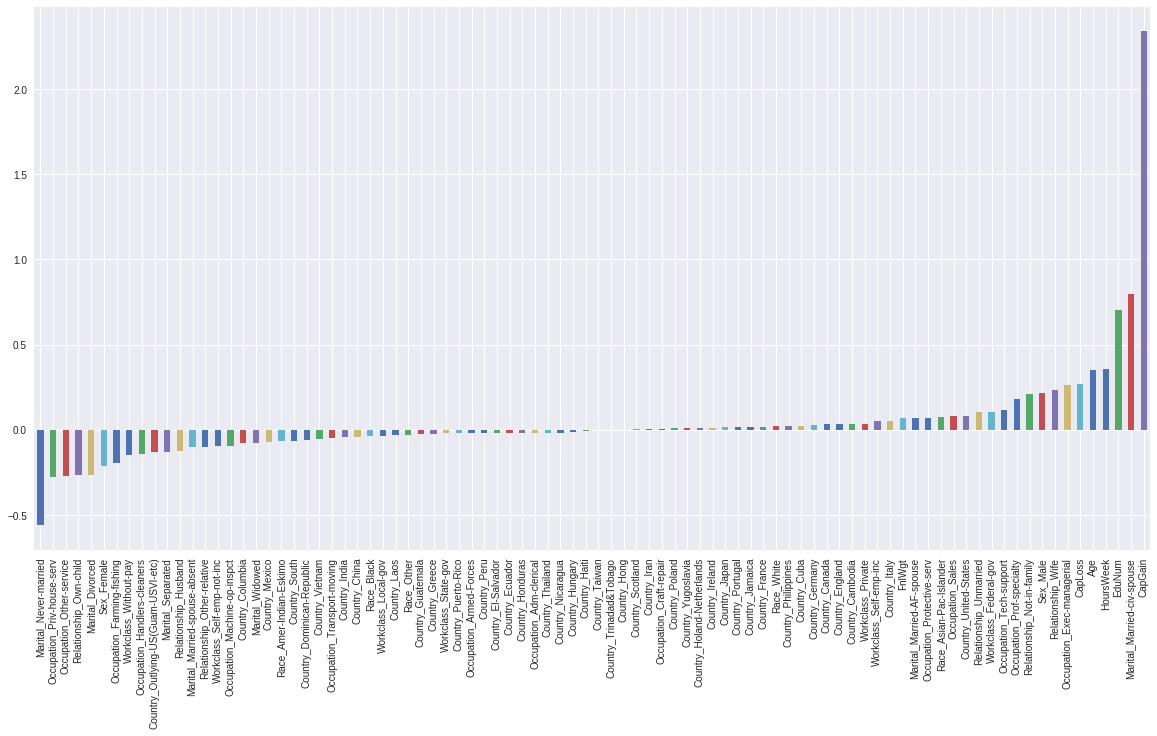

In [42]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
coefs.sort_values(inplace=True)
plt.figure(figsize=(20,10))
coefs.plot(kind="bar")

Magnificent. Remember how our model on the previous transformation virtually rendered `Occupation` as worthless. You can appreciate how important this feature was and we nearly missed that. Who's dummy now?!

Next we are going to investigate Regularization. In the assignment, I mentioned `LassoCV` and `RidgeCV`. Here instead, mostly for the sake of brevity, I'm going to use [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) instead.

In [0]:
penalty = ['l1', 'l2']

# penalty = ['l2']

# C is the inverese of regularization parameter (the proper range 
# that I had mentioned!)
C = np.logspace(-4, 4, 10)

random_state=[0]

# creating a dictionary of hyperparameters
hyperparameters = dict(C=C, penalty=penalty, 
                  random_state=random_state)

In [45]:
cls = LogisticRegression(solver='liblinear') 
# We can't use lbfgs solver since we want to fit LASSO

clf = GridSearchCV(estimator = cls, param_grid = hyperparameters, cv=2) #10 folds

best_model = clf.fit(X_train, y_train)
print('Best Penalty:', best_model.best_estimator_.get_params() ['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 0.046415888336127774


In [46]:
y_pred = best_model.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
print("F1 score: {:6f}".format(metrics.f1_score(y_test, y_pred)))
print("Accuracy: {:6f}".format(metrics.accuracy_score(y_test, y_pred)))
#Other performance metrics are not reported for the sake of brevity

F1 score: 0.673827
Accuracy: 0.848997


### More sophisticated models
<h1>SVM</h1>

For SVM, we use the data we prepared with LabelEncoder. 

OneHot is not appropriate and we don't wanna get into more advanced encodings. SVM is a black-box model, so we won't have any interpretation of the model.

In [0]:
#Split train and test, with test holing 20% of the samples belonging to each class
df_class_0_train, df_class_0_test = train_test_split(df_scaled[df_scaled['Target']==0], test_size=0.2)
df_class_1_train, df_class_1_test = train_test_split(df_scaled[df_scaled['Target']==1], test_size=0.2)

train_df = pd.concat([df_class_0_train, df_class_1_train])
test_df  = pd.concat([df_class_0_test, df_class_1_test])

#Shuffle train data
train_df = train_df.sample(frac=1, random_state=0)

X_train = train_df.drop('Target', axis=1)
y_train = train_df['Target']

X_test = test_df.drop('Target', axis=1)
y_test = test_df['Target']

In [0]:
from sklearn.svm import SVC

Kernel LINEAR
	Accuracy: 0.804078
	F1 score: 0.438213
	AUC: 0.6379025714555242
[[4390  141]
 [1041  461]]
Kernel SIGMOID
	Accuracy: 0.759821
	F1 score: 0.502916
	AUC: 0.6689693665269673
[[3851  680]
 [ 769  733]]
Kernel POLY
	Accuracy: 0.836234
	F1 score: 0.593416
	AUC: 0.717170675985319
[[4324  207]
 [ 781  721]]
Kernel RBF
	Accuracy: 0.841704
	F1 score: 0.627680
	AUC: 0.7395054956519388
[[4273  258]
 [ 697  805]]


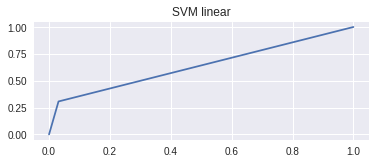

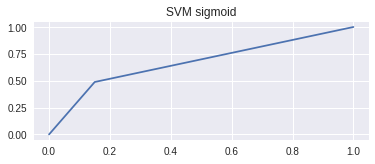

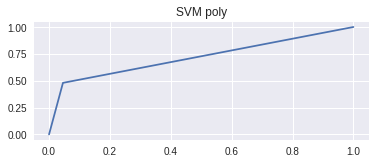

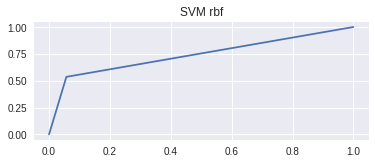

In [49]:
for i, kernel in enumerate(['linear', 'sigmoid', 'poly', 'rbf']):
  print('Kernel', kernel.upper())
  svc = SVC(kernel=kernel, C=1, gamma='auto')
  svc.fit(X_train, y_train)
  y_pred = svc.predict(X_test)
  print("\tAccuracy: {:6f}".format(metrics.accuracy_score(y_test, y_pred)))
  print("\tF1 score: {:6f}".format(metrics.f1_score(y_test, y_pred)))
  fig = plt.figure(figsize=(6,10))
  ax = fig.add_subplot(4, 1, i + 1)
  ax.set_title("SVM {}".format(kernel))
  fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred)
  auc = metrics.roc_auc_score(y_test, y_pred)
  print('\tAUC:', auc)
  print(metrics.confusion_matrix(y_test, y_pred))
  
  plt.plot(fpr, tpr)


<h1>Decision Tree and Random Forest</h1>

Next we are going to investigate Decision Trees. 

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
#Split train and test, with test holing 20% of the samples belonging to each class
df_class_0_train, df_class_0_test = train_test_split(encoded_df[encoded_df['Target']==0], test_size=0.2)
df_class_1_train, df_class_1_test = train_test_split(encoded_df[encoded_df['Target']==1], test_size=0.2)

train_df = pd.concat([df_class_0_train, df_class_1_train])
test_df  = pd.concat([df_class_0_test, df_class_1_test])

#Shuffle train data
train_df = train_df.sample(frac=1, random_state=0)

X_train = train_df.drop('Target', axis=1)
y_train = train_df['Target']

X_test = test_df.drop('Target', axis=1)
y_test = test_df['Target']

	Accuracy: 0.851318
	F1 score: 0.646989
	AUC: 0.7496890043761266
[[4314  217]
 [ 680  822]]


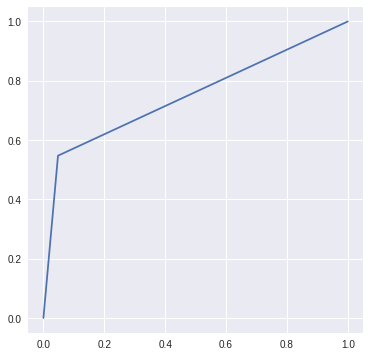

In [52]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print("\tAccuracy: {:6f}".format(metrics.accuracy_score(y_test, y_pred)))
print("\tF1 score: {:6f}".format(metrics.f1_score(y_test, y_pred)))
fig = plt.figure(figsize=(6,6))
ax.set_title("DT")
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
print('\tAUC:', auc)
plt.plot(fpr, tpr)
print(metrics.confusion_matrix(y_test, y_pred))

In [53]:
import numpy as np
import matplotlib.pyplot as plt

importances = tree.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X_train.columns.values[indices[f]], 
                            importances[indices[f]]))


 1) Relationship                   0.455412
 2) CapGain                        0.229735
 3) EduNum                         0.225196
 4) CapLoss                        0.067345
 5) HoursWeek                      0.013716
 6) Occupation                     0.005793
 7) Age                            0.001326
 8) FnlWgt                         0.001088
 9) Workclass                      0.000389
10) Country                        0.000000
11) Sex                            0.000000
12) Race                           0.000000
13) Marital                        0.000000


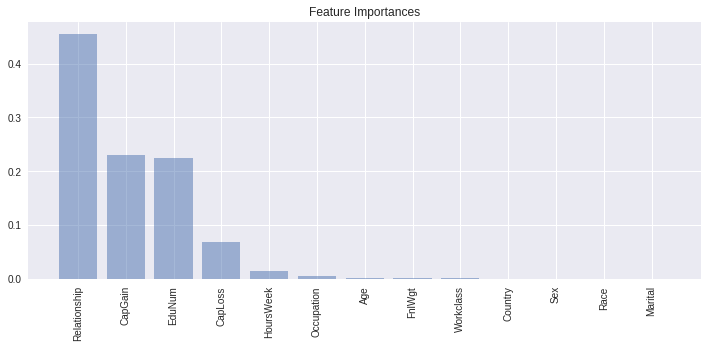

In [54]:
plt.figure(figsize=(10,5))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center',
        alpha=0.5)

plt.xticks(range(X_train.shape[1]), 
           X_train.columns.values[indices], rotation=90)
plt.tight_layout()
plt.show()

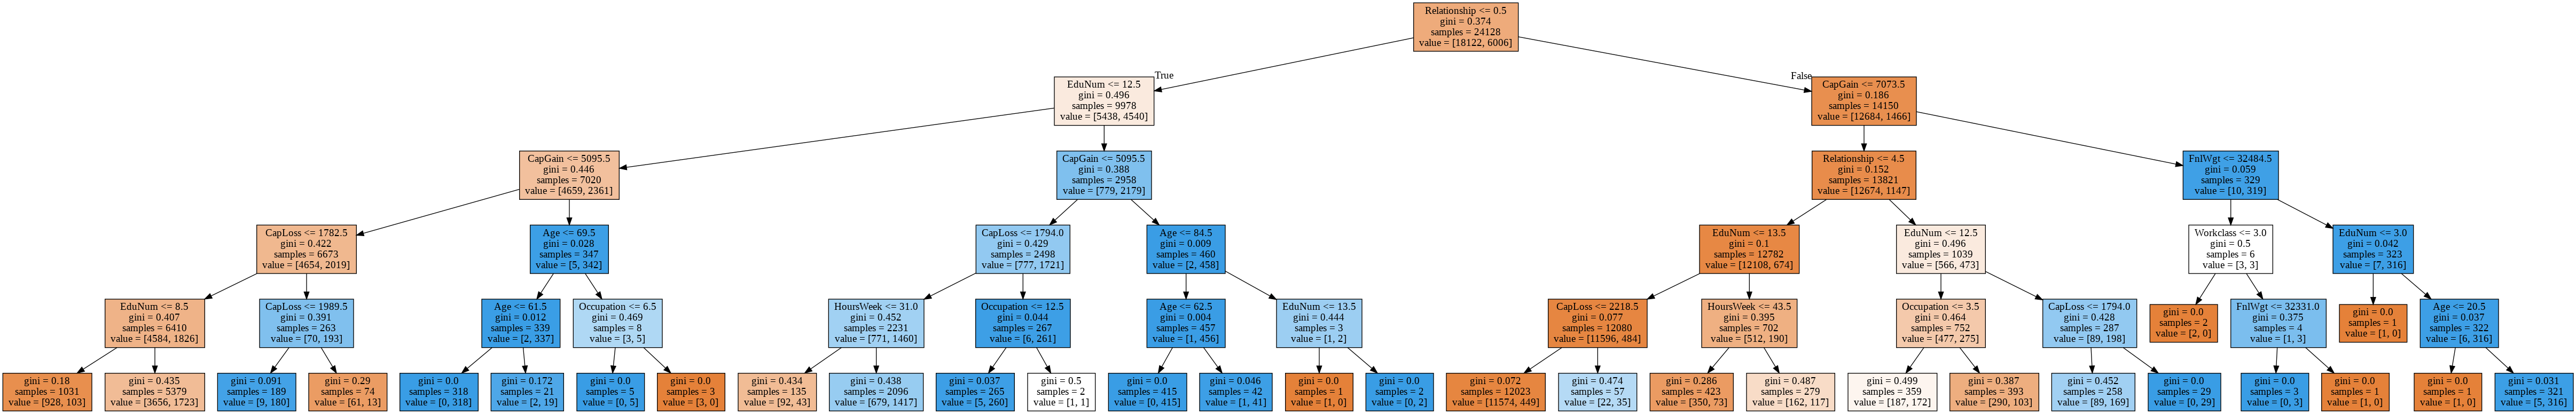

In [55]:
from sklearn.tree import export_graphviz
from IPython.display import Image, display
import pydotplus
from sklearn.externals.six import StringIO

def jupyter_graphviz(m, **kwargs):
    dot_data = StringIO()
    export_graphviz(m, dot_data, **kwargs)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    display(Image(graph.create_png()))
    
jupyter_graphviz(tree, filled=True, feature_names=X_train.columns.values)